<a href="https://colab.research.google.com/github/seemazml/Gesture_Recognition/blob/main/Final_Gesture_assigment_colab_work_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition
Build a 3D Conv model that will be able to predict the 5 gestures correctly.

**Objectives:**

**Generator:** The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

**Model:**Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

**Write up:**This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

In [ ]:
import numpy as np
import os
#from scipy.misc import imread, imresize
import datetime
import cv2
import pathlib
import matplotlib.pyplot as plt

In [ ]:
#Import model libraries
from keras.models import Sequential, Model
from keras.layers import Conv2D,MaxPooling2D, Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM, Bidirectional
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.applications import mobilenet

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [ ]:
#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL" -O Project_data.zip && rm -rf /tmp/cookies.txt

In [ ]:
## Mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
#Setting up root path - Point your project root path
#root_path = 'gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/' # For Sahoo's colab
# Defining the path for train and test images - Point the path where the test and train data directories
#data_dir = pathlib.Path(os.path.join(root_path,"Project_data")) # For Sahoo's colab



In [ ]:
#For Seema's Colab path

root_path = '/content/gdrive/MyDrive/Gesture_Recognition/'
data_dir = pathlib.Path(os.path.join(root_path,"Project_data")) 

In [ ]:
#checking gpu
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun May  2 13:42:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#checking RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
# train_doc = np.random.permutation(open(os.path.join(data_dir,'train.csv')).readlines())
# val_doc = np.random.permutation(open(os.path.join(data_dir,'val.csv')).readlines())
# batch_size = 40 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
# def generator(source_path, folder_list, batch_size):
#     print( 'Source path = ', source_path, '; batch size =', batch_size)
#     img_idx = [0,1,2,3,7,8,9,14,15,16,19,20,21,26,27,28] #create a list of image numbers you want to use for a particular video
#     while True:
#         t = np.random.permutation(folder_list)
#         num_batches = int(len(folder_list)/batch_size)# calculate the number of batches
#         for batch in range(num_batches): # we iterate over the number of batches
#             x = len(img_idx)
#             batch_data = np.zeros((batch_size,x,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
#             batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
#             for folder in range(batch_size): # iterate over the batch_size
#                 imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
#                 for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
#                     image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
#                     #crop the images and resize them. Note that the images are of 2 different shape 
#                     #and the conv3D will throw error if the inputs in a batch have different shapes
#                     height, width , channel = image.shape
#                     if height == 120 or width == 120:
#                         image=image[20:140,:120,:]

#                     #resizing all iamge to 100*100
#                     image = cv2.resize(image,(100,100))
                    
#                     image = image/255
#                     batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
#                     batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
#                     batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
#                 batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#             yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
#         # write the code for the remaining data points which are left after full batches
#         if len(folder_list) > num_batches * batch_size:
#             x=len(img_idx)
#             remaining_data_size = len(folder_list) - (num_batches * batch_size)
#             batch_data = np.zeros((remaining_data_size,x,100,100,3))
#             batch_labels = np.zeros((remaining_data_size,5)) # batch_labels is the one hot representation of the output
#             for folder in range(remaining_data_size): # iterate over the batch_size
#                 imgs = os.listdir(source_path+'/'+ t[folder + (num_batches * batch_size)].split(';')[0]) # read all the images in the folder
#                 for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
#                     image = imread(source_path+'/'+ t[folder + (num_batches * batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

#                     #cropping an image if size height or width is 120* 160
#                     height, width , channel = image.shape
#                     if height == 120 or width == 120:
#                         image=image[20:140,:120,:]
                    
#                     image = cv2.resize(image,(100,100))
                    
#                     #normalise and feed in the image
#                     image = image/255
#                     batch_data[folder,idx,:,:,0] = image[:,:,0]
#                     batch_data[folder,idx,:,:,1] = image[:,:,1]
#                     batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
#                 batch_labels[folder, int(t[folder + (num_batches * batch_size)].strip().split(';')[2])] = 1
#             yield batch_data, batch_labels


In [ ]:
# Let's build a flexible generator that would allow us to change settings for different experimentations without creating another generator code block
from typing import Tuple
class GeneratorTrainingBuilder:
  """
  Yields images per provided settings and fits the passed model
  """
  def __init__(self, base_path, batch_size:int, img_height_width:Tuple[int,int]=(100,100), img_idx:list = [x for x in range(0,30)]):
    """
    base_path: base path where train and val folders present
    batch_size: desired batch size , can be used to tune different batch size for experimentation
    img_heigh_width: A tupe for image size
    img_idx : Default all 30 images will be used unless a custom index list is passed

    """
    self.base_path = base_path
    self.batch_size = batch_size
    self.img_height_width = img_height_width
    self.y = img_height_width[0]
    self.z = img_height_width[1]
    self.img_idx = img_idx
    self.train_doc = np.random.permutation(open(os.path.join(self.base_path,'train.csv')).readlines())
    self.val_doc = np.random.permutation(open(os.path.join(self.base_path,'val.csv')).readlines())
    self.train_path = os.path.join(self.base_path,'train')
    self.val_path = os.path.join(self.base_path,'val')
    self.num_train_sequences = len(self.train_doc)
    print('# training sequences =', self.num_train_sequences)
    self.num_val_sequences = len(self.val_doc)
    print('# validation sequences =', self.num_val_sequences)

  def generator(self, source_path, folder_list):
    """
    source_path : Path of train or test data
    folder_list: List of file paths from the csv helper file
    """
    print( '\n', 'Source path = ', source_path, '; batch size =', self.batch_size , ';image dimension= ' , self.img_height_width)
    #img_idx = [0,1,2,3,7,8,9,14,15,16,19,20,21,26,27,28] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/self.batch_size)# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            x = len(self.img_idx)
            batch_data = np.zeros((self.batch_size,x,self.y,self.z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((self.batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(self.batch_size): # iterate over the batch_size
                imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch*self.batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(self.img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*self.batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    height, width , channel = image.shape
                    if height == 120 or width == 120:
                        image=image[20:140,:120,:]

                    #resizing all iamge to 100*100
                    image = cv2.resize(image,(self.y,self.z))
                    
                    image = image/255
                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*self.batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(folder_list) > num_batches * self.batch_size:
            x=len(self.img_idx)
            remaining_data_size = len(folder_list) - (num_batches * self.batch_size)
            batch_data = np.zeros((remaining_data_size,x,self.y,self.z,3))
            batch_labels = np.zeros((remaining_data_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(remaining_data_size): # iterate over the batch_size
                imgs = sorted(os.listdir(source_path+'/'+ t[folder + (num_batches * self.batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(self.img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches * self.batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #cropping an image if size height or width is 120* 160
                    height, width , channel = image.shape
                    if height == 120 or width == 120:
                        image=image[20:140,:120,:]
                    
                    image = cv2.resize(image,(self.y,self.z))
                    
                    #normalise and feed in the image
                    image = image/255
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (num_batches * self.batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

  def train(self, model=None, num_epochs = 2, model_identifier_name=None):
    """
    Trains the passed model
    """
    print ('# epochs =', num_epochs)
    train_generator = self.generator(self.train_path, self.train_doc)
    val_generator = self.generator(self.val_path, self.val_doc)
    curr_dt_time = datetime.datetime.now()
    model_identifier_name = model_identifier_name if model_identifier_name else '_'+model_identifier_name
    model_name = root_path + 'Gest_recog' + model_identifier_name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
  
    if not os.path.exists(model_name):
        os.mkdir(model_name)
            
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5) #, min_lr=0.0001) # write the REducelronplateau code here

    earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=5,verbose=1)

    callbacks_list = [checkpoint, LR, earlystop]

    if (self.num_train_sequences%self.batch_size) == 0:
        steps_per_epoch = int(self.num_train_sequences/self.batch_size)
    else:
        steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

    print ('# steps per epoch =', steps_per_epoch)

    if (self.num_val_sequences%self.batch_size) == 0:
        validation_steps = int(self.num_val_sequences/self.batch_size)
    else:
        validation_steps = (self.num_val_sequences//self.batch_size) + 1

    print ('# validation steps = ', validation_steps)

    fitted_model = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                  callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, 
                  class_weight=None, workers=1, initial_epoch=0)
    
    self.plot_history(fitted_model, model)

    return fitted_model

  # to plot the model accuracy , lets create a generic plot function 
  def plot_history(self, history, model):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(model.history.epoch))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Categorical Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Categorical Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
# curr_dt_time = datetime.datetime.now()
# train_path = os.path.join(data_dir,'train')
# val_path = os.path.join(data_dir,'val')
# num_train_sequences = len(train_doc)
# print('# training sequences =', num_train_sequences)
# num_val_sequences = len(val_doc)
# print('# validation sequences =', num_val_sequences)
# num_epochs = 3 # choose the number of epochs
# print ('# epochs =', num_epochs)

# Models
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Base Model

In [ ]:


#write your model here
#Lets first build a Base model first
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=(15,100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, (3, 3, 3), padding='same', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(128, (3, 3, 3), padding='same', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))

model.add(Dense(5, activation='softmax'))
#model = Sequential()
#model.add(TimeDistributed(cnn, input_shape=(16, 100, 100,3)))
#model.add(Bidirectional(GRU(16)))
#model.add(Dropout(.2)) #added
#model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = 'Adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 15, 100, 100, 32)  2624      
_________________________________________________________________
batch_normalization_3 (Batch (None, 15, 100, 100, 32)  128       
_________________________________________________________________
activation_3 (Activation)    (None, 15, 100, 100, 32)  0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 7, 50, 50, 32)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 7, 50, 50, 64)     55360     
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 50, 50, 64)     256       
_________________________________________________________________
activation_4 (Activation)    (None, 7, 50, 50, 64)    

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

Lets use our generic GeneratorModelBuilder class with various params and pass the above baseline model

# training sequences = 663
# validation sequences = 100
# epochs = 5
# steps per epoch = 23
# validation steps =  4

 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 30 ;image dimension=  (100, 100)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
22/23 [===========================>..] - ETA: 2s - loss: 5.2467 - categorical_accuracy: 0.2185
 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/val ; batch size = 30 ;image dimension=  (100, 100)
23/23 [==============================] - 58s 3s/step - loss: 5.0805 - categorical_accuracy: 0.2218 - val_loss: 3.2044 - val_categorical_accuracy: 0.1700

Epoch 00001: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Gest_recog_base_model_2021-05-0217_38_02.893819/model-00001-3.25131-0.25792-3.20437-0.17000.h5
Epoch 2/5
23/23 [==============================] - 57s 3s/step - loss: 1.4091 - categorical_accuracy: 0.3394 - val_loss: 1.9566 - val_categorical_accuracy: 0.2700

Epoch 00002: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Gest_recog_base_model_2021-05-0217_38_02.893819/model-00002-1.41519-0.34540-1.95665-0.27000.h5
Epoch 3/5
23/23 [==============================] - 55s 3s/step - loss: 1.3348 - categorical_accuracy: 0.3697 - val_l

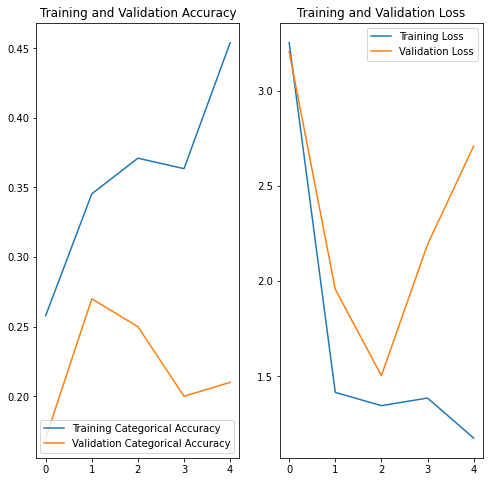

In [ ]:
base_model_trainer = GeneratorTrainingBuilder(base_path=data_dir, batch_size = 30, img_height_width=(100, 100), img_idx=[1,2,3,7,8,9,14,15,16,19,20,21,26,27,28])
trained_out = base_model_trainer.train(model=model, num_epochs=5, model_identifier_name='_base_model')

Let us train the model with different batch sizes

# training sequences = 663
# validation sequences = 100
# epochs = 5
# steps per epoch = 45
# validation steps =  7

 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 15 ;image dimension=  (100, 100)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
45/45 [==============================] - ETA: 0s - loss: 1.1873 - categorical_accuracy: 0.4962
 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/val ; batch size = 15 ;image dimension=  (100, 100)
45/45 [==============================] - 57s 1s/step - loss: 1.1873 - categorical_accuracy: 0.4962 - val_loss: 1.9400 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Gest_recogbase_model_2021-05-0215_29_12.062686/model-00001-1.18730-0.49623-1.94004-0.23000.h5
Epoch 2/5
45/45 [==============================] - 56s 1s/step - loss: 1.0470 - categorical_accuracy: 0.5475 - val_loss: 3.7175 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Gest_recogbase_model_2021-05-0215_29_12.062686/model-00002-1.04698-0.54751-3.71752-0.25000.h5
Epoch 3/5
45/45 [==============================] - 56s 1s/step - loss: 1.0214 - categorical_accuracy: 0.5807 - val_los

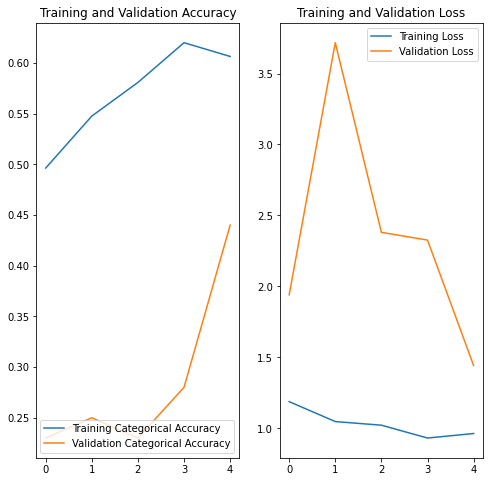

In [ ]:
base_model_trainer = GeneratorTrainingBuilder(base_path=data_dir, batch_size = 15, img_height_width=(100, 100), img_idx=[1,2,3,7,8,9,14,15,16,19,20,21,26,27,28])
trained_out = base_model_trainer.train(model=model, num_epochs=5, model_identifier_name='base_model')

Lets try with Batch size 60

# training sequences = 663
# validation sequences = 100
# epochs = 2
# steps per epoch = 12
# validation steps =  2

 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 60 ;image dimension=  (100, 100)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
12/12 [==============================] - ETA: 0s - loss: 1.2354 - categorical_accuracy: 0.4012
 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/val ; batch size = 60 ;image dimension=  (100, 100)
12/12 [==============================] - 48s 4s/step - loss: 1.2354 - categorical_accuracy: 0.4012 - val_loss: 2.4643 - val_categorical_accuracy: 0.1700

Epoch 00001: val_loss improved from inf to 2.46426, saving model to Gest_recogbase_model_2021-04-2818_22_13.616295/model-00001-1.23539-0.40121-2.46426-0.17000.h5
Epoch 2/2
12/12 [==============================] - 46s 4s/step - loss: 1.1692 - categorical_accuracy: 0.4495 - val_loss: 3.2974 - val_categorical_accuracy: 0.1500

Epoch 00002: val_loss did not improve from 2.46426


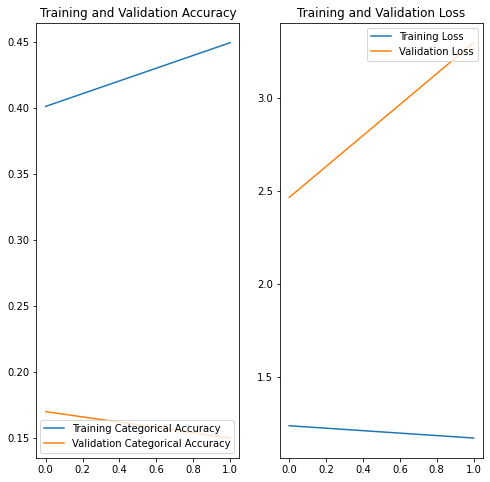

In [ ]:
base_model_trainer = GeneratorTrainingBuilder(base_path=data_dir, batch_size = 60, img_height_width=(100, 100), img_idx=[1,2,3,7,8,9,14,15,16,19,20,21,26,27,28])
trained_out = base_model_trainer.train(model=model, num_epochs=2, model_identifier_name='base_model')

# training sequences = 663
# validation sequences = 100
# epochs = 3
# steps per epoch = 10
# validation steps =  2

 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 70 ;image dimension=  (100, 100)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
10/10 [==============================] - ETA: 0s - loss: 1.4189 - categorical_accuracy: 0.3861
 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/val ; batch size = 70 ;image dimension=  (100, 100)
10/10 [==============================] - 49s 5s/step - loss: 1.4189 - categorical_accuracy: 0.3861 - val_loss: 2.6622 - val_categorical_accuracy: 0.2400

Epoch 00001: val_loss improved from inf to 2.66216, saving model to Gest_recogbase_model_2021-04-2818_23_51.930876/model-00001-1.41888-0.38612-2.66216-0.24000.h5
Epoch 2/3
10/10 [==============================] - 46s 5s/step - loss: 1.3521 - categorical_accuracy: 0.3560 - val_loss: 1.8841 - val_categorical_accuracy: 0.2100

Epoch 00002: val_loss improved from 2.66216 to 1.88414, saving model to Gest_recogbase_model_2021-04-2818_23_51.930876/model-00002-1.35206-0.35596-1.88414-0.21000.h5
Epoch 3/3
10/10 [==============================] - 48s 5s/step - loss: 1.3331 - categorical_accuracy: 0.3786 - val_loss: 1.9

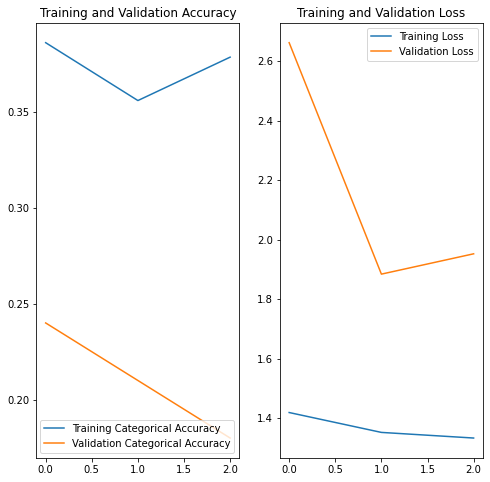

In [ ]:
base_model_trainer = GeneratorTrainingBuilder(base_path=data_dir, batch_size = 70, img_height_width=(100, 100), img_idx=[1,2,3,7,8,9,14,15,16,19,20,21,26,27,28])
trained_out = base_model_trainer.train(model=model, num_epochs=3, model_identifier_name='base_model')

# training sequences = 663
# validation sequences = 100
# epochs = 20
# steps per epoch = 23
# validation steps =  4

 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 30 ;image dimension=  (100, 100)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 0.7168 - categorical_accuracy: 0.7179
 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/val ; batch size = 30 ;image dimension=  (100, 100)
23/23 [==============================] - 56s 3s/step - loss: 0.7168 - categorical_accuracy: 0.7179 - val_loss: 1.1476 - val_categorical_accuracy: 0.5000

Epoch 00001: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Gest_recogbase_model_2021-05-0215_36_58.796237/model-00001-0.71682-0.71795-1.14756-0.50000.h5
Epoch 2/20
23/23 [==============================] - 56s 3s/step - loss: 0.6322 - categorical_accuracy: 0.7104 - val_loss: 1.0588 - val_categorical_accuracy: 0.5700

Epoch 00002: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Gest_recogbase_model_2021-05-0215_36_58.796237/model-00002-0.63221-0.71041-1.05881-0.57000.h5
Epoch 3/20
23/23 [==============================] - 57s 3s/step - loss: 0.5948 - categorical_accuracy: 0.7436 - val_

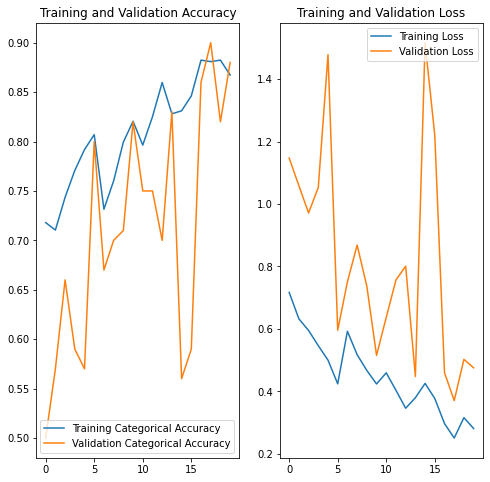

In [ ]:
base_model_trainer = GeneratorTrainingBuilder(base_path=data_dir, batch_size = 30, img_height_width=(100, 100), img_idx=[1,2,3,7,8,9,14,15,16,19,20,21,26,27,28])
trained_out = base_model_trainer.train(model=model, num_epochs=20, model_identifier_name='base_model')

## Experimentation with Conv3D models

### Model 1 - filter (3, 3, 3) Batch size 60, epochs = 30, SGD Optimiser

In [ ]:
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=(15,100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, (3, 3, 3), padding='same', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(128, (3, 3, 3), padding='same', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))

model.add(Dense(5, activation='softmax'))

optimiser = 'SGD' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 15, 100, 100, 32)  2624      
_________________________________________________________________
batch_normalization_3 (Batch (None, 15, 100, 100, 32)  128       
_________________________________________________________________
activation_3 (Activation)    (None, 15, 100, 100, 32)  0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 7, 50, 50, 32)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 7, 50, 50, 64)     55360     
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 50, 50, 64)     256       
_________________________________________________________________
activation_4 (Activation)    (None, 7, 50, 50, 64)    

# training sequences = 663
# validation sequences = 100
# epochs = 30
# steps per epoch = 12
# validation steps =  2

 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 60 ;image dimension=  (100, 100)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 2.2166 - categorical_accuracy: 0.2318
 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/val ; batch size = 60 ;image dimension=  (100, 100)
12/12 [==============================] - 49s 4s/step - loss: 2.2007 - categorical_accuracy: 0.2320 - val_loss: 1.5912 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss improved from inf to 1.59123, saving model to Gest_recogbase_model_2021-04-2818_26_19.099923/model-00001-2.01055-0.23529-1.59123-0.23000.h5
Epoch 2/30
12/12 [==============================] - 46s 4s/step - loss: 1.6462 - categorical_accuracy: 0.3013 - val_loss: 1.5928 - val_categorical_accuracy: 0.2000

Epoch 00002: val_loss did not improve from 1.59123
Epoch 3/30
12/12 [==============================] - 47s 4s/step - loss: 1.7278 - categorical_accuracy: 0.3138 - val_loss: 1.5866 - val_categorical_accuracy: 0.2700

Epoch 00003: val_loss improved from 1.59123 to 1.58657, saving model to 

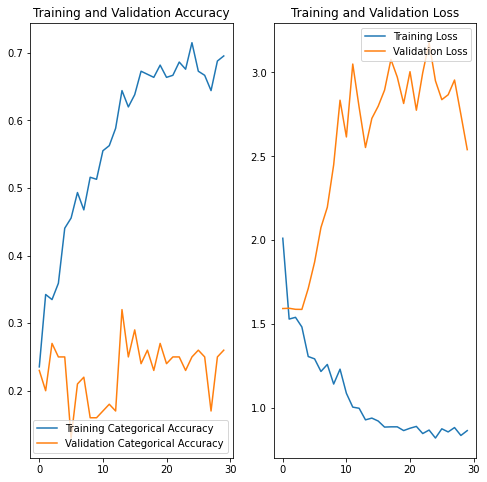

In [ ]:
model1_trainer = GeneratorTrainingBuilder(base_path=data_dir, batch_size = 60, img_height_width=(100, 100), img_idx=[1,2,3,7,8,9,14,15,16,19,20,21,26,27,28])
trained_out = model1_trainer.train(model=model, num_epochs=30, model_identifier_name='model_1')

### Model 2 - Adding more layers and dropouts

In [ ]:
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=(15,100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, (3, 3, 3), padding='same', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, (3, 3, 3), padding='same', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_38 (Conv3D)           (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
batch_normalization_38 (Batc (None, 15, 100, 100, 16)  64        
_________________________________________________________________
activation_38 (Activation)   (None, 15, 100, 100, 16)  0         
_________________________________________________________________
conv3d_39 (Conv3D)           (None, 15, 100, 100, 16)  6928      
_________________________________________________________________
batch_normalization_39 (Batc (None, 15, 100, 100, 16)  64        
_________________________________________________________________
activation_39 (Activation)   (None, 15, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_36 (MaxPooling (None, 7, 50, 50, 16)   

# training sequences = 663
# validation sequences = 100
# epochs = 30
# steps per epoch = 17
# validation steps =  3

 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 40 ;image dimension=  (100, 100)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 2.0491 - categorical_accuracy: 0.2168
 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/val ; batch size = 40 ;image dimension=  (100, 100)
17/17 [==============================] - 50s 3s/step - loss: 2.0358 - categorical_accuracy: 0.2205 - val_loss: 1.5622 - val_categorical_accuracy: 0.2900

Epoch 00001: val_loss improved from inf to 1.56215, saving model to Gest_recogbase_model_2021-04-2819_28_52.061284/model-00001-1.80951-0.28356-1.56215-0.29000.h5
Epoch 2/30
17/17 [==============================] - 47s 3s/step - loss: 1.4007 - categorical_accuracy: 0.3826 - val_loss: 1.5860 - val_categorical_accuracy: 0.2200

Epoch 00002: val_loss did not improve from 1.56215
Epoch 3/30
17/17 [==============================] - 48s 3s/step - loss: 1.1593 - categorical_accuracy: 0.5426 - val_loss: 1.6058 - val_categorical_accuracy: 0.2000

Epoch 00003: val_loss did not improve from 1.56215
Epoch 4/30
17/17 [===

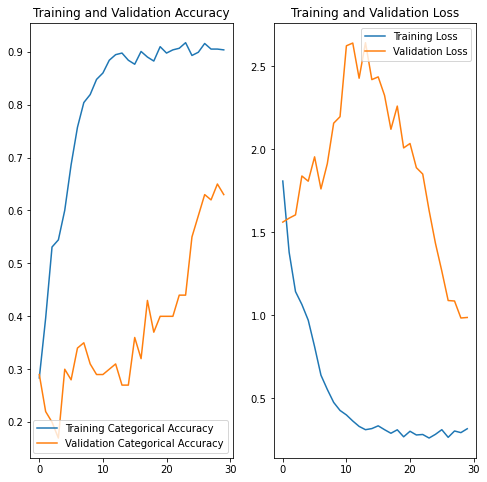

In [ ]:
model2_trainer = GeneratorTrainingBuilder(base_path=data_dir, batch_size = 40, img_height_width=(100, 100), img_idx=[1,2,3,7,8,9,14,15,16,19,20,21,26,27,28])
trained_out = model2_trainer.train(model=model, num_epochs=30, model_identifier_name='model_2')

### Model 3 - We see a considerable improvement in Accuracy and reduction in loss. But the model is still overfitting. Lets try to increase more layers and add dropouts

In [ ]:
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=(15,100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=(15,100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.2))

model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.4))

model.add(Conv3D(64, (3, 3, 3), padding='same', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(64, (3, 3, 3), padding='same', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_48 (Conv3D)           (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
batch_normalization_48 (Batc (None, 15, 100, 100, 16)  64        
_________________________________________________________________
activation_48 (Activation)   (None, 15, 100, 100, 16)  0         
_________________________________________________________________
conv3d_49 (Conv3D)           (None, 15, 100, 100, 16)  6928      
_________________________________________________________________
batch_normalization_49 (Batc (None, 15, 100, 100, 16)  64        
_________________________________________________________________
activation_49 (Activation)   (None, 15, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_43 (MaxPooling (None, 7, 50, 50, 16)   

# training sequences = 663
# validation sequences = 100
# epochs = 30
# steps per epoch = 17
# validation steps =  3

 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 40 ;image dimension=  (100, 100)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 1.9106 - categorical_accuracy: 0.2836
 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/val ; batch size = 40 ;image dimension=  (100, 100)
17/17 [==============================] - 50s 3s/step - loss: 1.9021 - categorical_accuracy: 0.2841 - val_loss: 1.5764 - val_categorical_accuracy: 0.2200

Epoch 00001: val_loss improved from inf to 1.57641, saving model to Gest_recogbase_model_2021-04-2819_57_48.446205/model-00001-1.75868-0.29412-1.57641-0.22000.h5
Epoch 2/30
17/17 [==============================] - 48s 3s/step - loss: 1.5193 - categorical_accuracy: 0.3154 - val_loss: 1.5738 - val_categorical_accuracy: 0.2500

Epoch 00002: val_loss improved from 1.57641 to 1.57379, saving model to Gest_recogbase_model_2021-04-2819_57_48.446205/model-00002-1.45963-0.34087-1.57379-0.25000.h5
Epoch 3/30
17/17 [==============================] - 47s 3s/step - loss: 1.3327 - categorical_accuracy: 0.3938 - val_loss: 

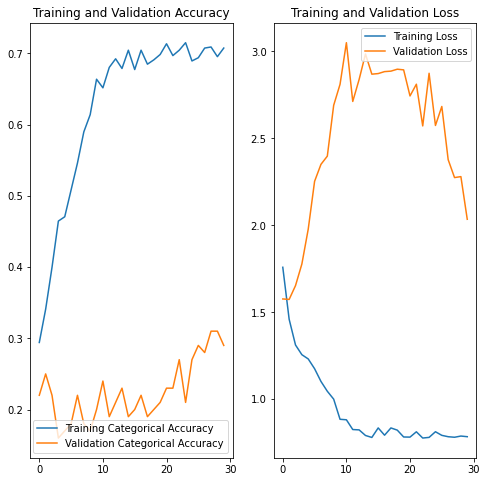

In [ ]:
model3_trainer = GeneratorTrainingBuilder(base_path=data_dir, batch_size = 40, img_height_width=(100, 100), img_idx=[1,2,3,7,8,9,14,15,16,19,20,21,26,27,28])
trained_out = model3_trainer.train(model=model, num_epochs=30, model_identifier_name='model_3')

### Model 4 - There is no improvement in Model 3, lets improve on Model 2 by using a filer size (2,2,2)

In [ ]:
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=(15,100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(16, (2,2,2), padding='same', input_shape=(15,100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.2))

model.add(Conv3D(32, (2,2,2), padding='same', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, (2,2,2), padding='same', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.4))

model.add(Conv3D(64, (2,2,2), padding='same', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(64, (2,2,2), padding='same', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_54 (Conv3D)           (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
batch_normalization_54 (Batc (None, 15, 100, 100, 16)  64        
_________________________________________________________________
activation_54 (Activation)   (None, 15, 100, 100, 16)  0         
_________________________________________________________________
conv3d_55 (Conv3D)           (None, 15, 100, 100, 16)  2064      
_________________________________________________________________
batch_normalization_55 (Batc (None, 15, 100, 100, 16)  64        
_________________________________________________________________
activation_55 (Activation)   (None, 15, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_46 (MaxPooling (None, 7, 50, 50, 16)   

# training sequences = 663
# validation sequences = 100
# epochs = 30
# steps per epoch = 17
# validation steps =  3

 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 40 ;image dimension=  (100, 100)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 1.9112 - categorical_accuracy: 0.2235
 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/val ; batch size = 40 ;image dimension=  (100, 100)
17/17 [==============================] - 50s 3s/step - loss: 1.9030 - categorical_accuracy: 0.2257 - val_loss: 1.6093 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss improved from inf to 1.60933, saving model to Gest_recogmodel_4_2021-04-2820_32_18.378665/model-00001-1.76320-0.26395-1.60933-0.23000.h5
Epoch 2/30
17/17 [==============================] - 48s 3s/step - loss: 1.4363 - categorical_accuracy: 0.3316 - val_loss: 1.7426 - val_categorical_accuracy: 0.1500

Epoch 00002: val_loss did not improve from 1.60933
Epoch 3/30
17/17 [==============================] - 46s 3s/step - loss: 1.3446 - categorical_accuracy: 0.3831 - val_loss: 1.9470 - val_categorical_accuracy: 0.1200

Epoch 00003: val_loss did not improve from 1.60933
Epoch 4/30
17/17 [======

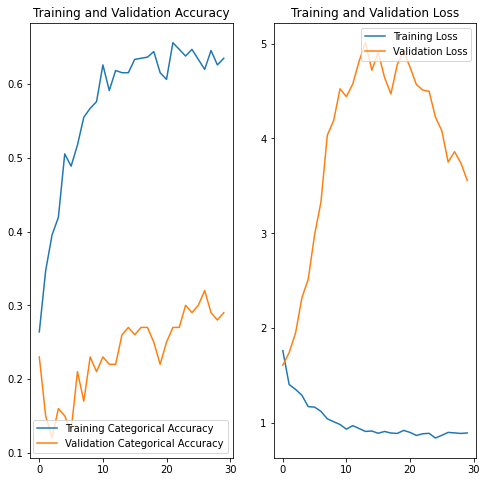

In [ ]:
model4_trainer = GeneratorTrainingBuilder(base_path=data_dir, batch_size = 40, img_height_width=(100, 100), img_idx=[1,2,3,7,8,9,14,15,16,19,20,21,26,27,28])
trained_out = model4_trainer.train(model=model, num_epochs=30, model_identifier_name='model_4')

### Model 5 - No improvement in reducing Filter size. Lets use (3,3,3) filter but try adding more dropouts

In [ ]:
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=(15,100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))


model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.4))

model.add(Conv3D(64, (3, 3, 3), padding='same', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 100, 100, 16)  64        
_________________________________________________________________
activation_4 (Activation)    (None, 15, 100, 100, 16)  0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 100, 100, 32)  13856     
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 100, 100, 32)  128       
_________________________________________________________________
activation_5 (Activation)    (None, 15, 100, 100, 32)  0         
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 7, 50, 50, 32)    

# training sequences = 663
# validation sequences = 100
# epochs = 30
# steps per epoch = 12
# validation steps =  2

 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 60 ;image dimension=  (100, 100)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 42.3586 - categorical_accuracy: 0.2378  
 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/val ; batch size = 60 ;image dimension=  (100, 100)
12/12 [==============================] - 2276s 206s/step - loss: 41.2363 - categorical_accuracy: 0.2382 - val_loss: 1.7576 - val_categorical_accuracy: 0.1700

Epoch 00001: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Gest_recogmodel_5_2021-04-3010_10_47.861998/model-00001-27.76780-0.24284-1.75763-0.17000.h5
Epoch 2/30
12/12 [==============================] - 69s 6s/step - loss: 1.6102 - categorical_accuracy: 0.1656 - val_loss: 1.6098 - val_categorical_accuracy: 0.1900

Epoch 00002: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Gest_recogmodel_5_2021-04-3010_10_47.861998/model-00002-1.61190-0.18401-1.60978-0.19000.h5
Epoch 3/30
12/12 [==============================] - 70s 6s/step - loss: 1.6096 - categorical_accuracy: 0.1871 - v

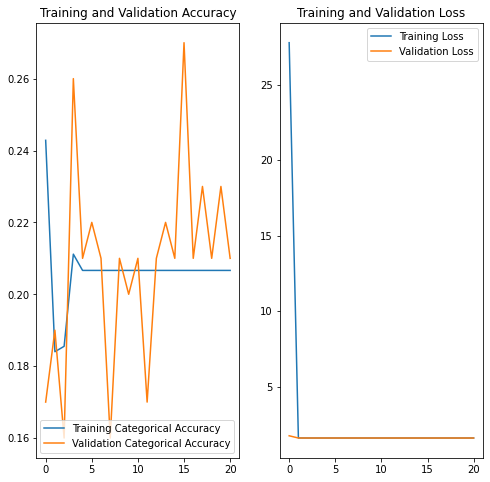

In [ ]:
model5_trainer = GeneratorTrainingBuilder(base_path=data_dir, batch_size = 60, img_height_width=(100, 100), img_idx=[1,2,3,7,8,9,14,15,16,19,20,21,26,27,28])
trained_out = model5_trainer.train(model=model, num_epochs=30, model_identifier_name='model_5')

### Model 6 - Try to reduce Parameters

In [ ]:
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=(15,100,100,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=(100,100,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, (3, 3, 3), padding='same', input_shape=(100,100,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(128, (3, 3, 3), padding='same', input_shape=(100,100,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Flatten())
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam(lr = 0.002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
activation_7 (Activation)    (None, 15, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 15, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 7, 50, 50, 32)     13856     
_________________________________________________________________
activation_8 (Activation)    (None, 7, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 50, 50, 32)    

# training sequences = 663
# validation sequences = 100
# epochs = 30
# steps per epoch = 12
# validation steps =  2

 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 60 ;image dimension=  (100, 100)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 1.7971 - categorical_accuracy: 0.4407
 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/val ; batch size = 60 ;image dimension=  (100, 100)
12/12 [==============================] - 71s 6s/step - loss: 1.7746 - categorical_accuracy: 0.4455 - val_loss: 8.9493 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Gest_recogmodel_6_2021-04-3011_21_48.364708/model-00001-1.50441-0.50226-8.94934-0.23000.h5
Epoch 2/30
12/12 [==============================] - 66s 6s/step - loss: 0.7749 - categorical_accuracy: 0.7186 - val_loss: 7.5728 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Gest_recogmodel_6_2021-04-3011_21_48.364708/model-00002-0.78971-0.70437-7.57282-0.21000.h5
Epoch 3/30
12/12 [==============================] - 68s 6s/step - loss: 0.8374 - categorical_accuracy: 0.6779 - val_loss: 

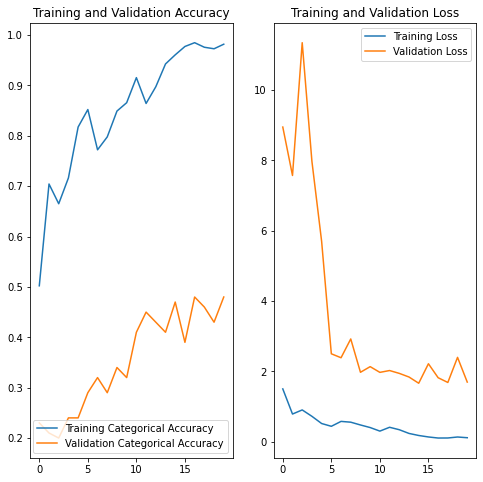

In [ ]:
model6_trainer = GeneratorTrainingBuilder(base_path=data_dir, batch_size = 60, img_height_width=(100, 100), img_idx=[1,2,3,7,8,9,14,15,16,19,20,21,26,27,28])
trained_out = model6_trainer.train(model=model, num_epochs=30, model_identifier_name='model_6')

### Model 7 - Reduce parameters further

In [ ]:
model = Sequential()
model.add(Conv3D(8, (3, 3, 3), padding='same', input_shape=(15,100,100,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=(100,100,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=(100,100,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, (3, 3, 3), padding='same', input_shape=(100,100,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam(lr = 0.002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_11 (Conv3D)           (None, 15, 100, 100, 8)   656       
_________________________________________________________________
activation_11 (Activation)   (None, 15, 100, 100, 8)   0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 15, 100, 100, 8)   32        
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 7, 50, 50, 8)      0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 7, 50, 50, 16)     3472      
_________________________________________________________________
activation_12 (Activation)   (None, 7, 50, 50, 16)     0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 7, 50, 50, 16)    

# training sequences = 663
# validation sequences = 100
# epochs = 30
# steps per epoch = 12
# validation steps =  2

 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 60 ;image dimension=  (100, 100)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 1.7451 - categorical_accuracy: 0.3811
 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/val ; batch size = 60 ;image dimension=  (100, 100)
12/12 [==============================] - 68s 6s/step - loss: 1.7288 - categorical_accuracy: 0.3845 - val_loss: 2.3262 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Gest_recogmodel_7_2021-04-3012_03_04.498307/model-00001-1.53370-0.42534-2.32616-0.23000.h5
Epoch 2/30
12/12 [==============================] - 63s 6s/step - loss: 1.0177 - categorical_accuracy: 0.6108 - val_loss: 1.4400 - val_categorical_accuracy: 0.3900

Epoch 00002: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Gest_recogmodel_7_2021-04-3012_03_04.498307/model-00002-1.02770-0.61237-1.44004-0.39000.h5
Epoch 3/30
12/12 [==============================] - 64s 6s/step - loss: 0.9657 - categorical_accuracy: 0.6115 - val_loss: 

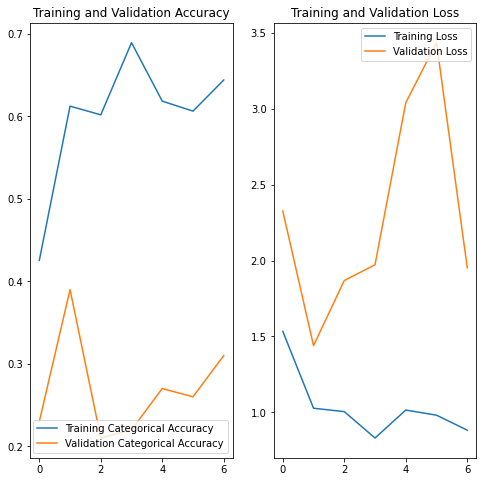

In [ ]:
model7_trainer = GeneratorTrainingBuilder(base_path=data_dir, batch_size = 60, img_height_width=(100, 100), img_idx=[1,2,3,7,8,9,14,15,16,19,20,21,26,27,28])
trained_out = model7_trainer.train(model=model, num_epochs=30, model_identifier_name='model_7')

## Experimentation with Conv2D + RNN (LSTM) approach

### CNN-LSTM Model 1

In [ ]:
# Base Model for CNN + LSTM 

img_idx2=[1,2,3,7,8,9,12,14,15,16,19,20,21,24,26,27,28]
img_height_width = (100,100)
input_shape = (len(img_idx2),img_height_width[0],img_height_width[1],3)

model_cnnlstm = Sequential()
model_cnnlstm.add(TimeDistributed(Conv2D(32, (6, 6), strides=(2, 2), activation='relu', padding='same'), input_shape=input_shape))
model_cnnlstm.add(TimeDistributed(Conv2D(32, (3,3), kernel_initializer="he_normal", activation='relu')))
model_cnnlstm.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model_cnnlstm.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model_cnnlstm.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model_cnnlstm.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model_cnnlstm.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model_cnnlstm.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model_cnnlstm.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model_cnnlstm.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
model_cnnlstm.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
model_cnnlstm.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model_cnnlstm.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
model_cnnlstm.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
model_cnnlstm.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model_cnnlstm.add(TimeDistributed(Flatten()))
 
model_cnnlstm.add(Dropout(0.25))
model_cnnlstm.add(LSTM(512, return_sequences=False, dropout=0.5))
model_cnnlstm.add(Dense(5, activation='softmax'))

# Model compile
optimiser = optimizers.Adam() #write your optimizer
model_cnnlstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_cnnlstm.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 17, 50, 50, 32)    3488      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 17, 48, 48, 32)    9248      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 17, 24, 24, 32)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 17, 24, 24, 64)    18496     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 17, 24, 24, 64)    36928     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 17, 12, 12, 64)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 17, 12, 12, 128)   7

# training sequences = 663
# validation sequences = 100
# epochs = 20
# steps per epoch = 17
# validation steps =  3

 Source path =  gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Project_data/train ; batch size = 40 ;image dimension=  (100, 100)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.6179 - categorical_accuracy: 0.1750  
 Source path =  gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Project_data/val ; batch size = 40 ;image dimension=  (100, 100)
17/17 [==============================] - 2424s 150s/step - loss: 1.6177 - categorical_accuracy: 0.1755 - val_loss: 1.6089 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss improved from inf to 1.60885, saving model to Gest_recog_model_cnnlstm_2021-04-2904_06_47.449560/model-00001-1.61408-0.18401-1.60885-0.23000.h5
Epoch 2/20
17/17 [==============================] - 66s 4s/step - loss: 1.6094 - categorical_accuracy: 0.2211 - val_loss: 1.6007 - val_categorical_accuracy: 0.2300

Epoch 00002: val_loss improved from 1.60885 to 1.60075, saving model to Gest_recog_model_cnnlstm_2021-04-2904_06_47.449560/model-00002-1.60963-0.21267-1.60075-0.23000.h5
Epoch 3/20
17/17 [==============================] - 65s 4s/step - loss: 1.6004 - categorica

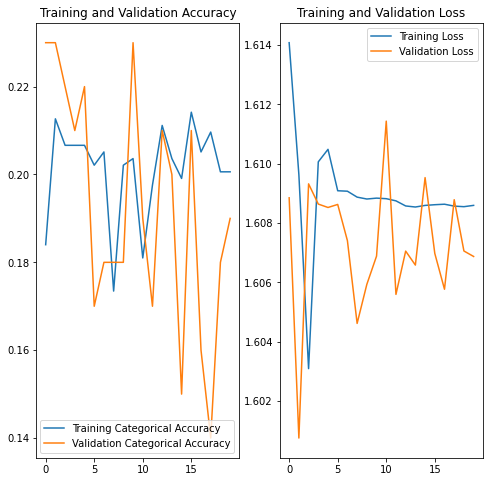

In [ ]:
model_cnnlstm_trainer = GeneratorTrainingBuilder(base_path=data_dir, batch_size = 40, img_height_width=(100, 100), img_idx=img_idx2)
model_cnnlstm_out = model_cnnlstm_trainer.train(model=model_cnnlstm, num_epochs=20, model_identifier_name='_model_cnnlstm')


### Increasing dropouts , changing Optimiser , reducing epoch (Higher epochs = Higher Training time)
#### CNN LSTM Model2

In [ ]:
img_idx2=[1,2,3,7,8,9,12,14,15,16,19,20,21,24,26,27,28]
img_height_width = (100,100)
input_shape = (len(img_idx2),img_height_width[0],img_height_width[1],3)

model_cnnlstm = Sequential()
model_cnnlstm.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2), activation='relu', padding='same'), input_shape=input_shape))
model_cnnlstm.add(TimeDistributed(Conv2D(32, (3,3), kernel_initializer="he_normal", activation='relu')))
model_cnnlstm.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model_cnnlstm.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model_cnnlstm.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model_cnnlstm.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model_cnnlstm.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model_cnnlstm.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model_cnnlstm.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model_cnnlstm.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
model_cnnlstm.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
model_cnnlstm.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model_cnnlstm.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
model_cnnlstm.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
model_cnnlstm.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model_cnnlstm.add(TimeDistributed(Flatten()))
 
model_cnnlstm.add(Dropout(0.50)) # Changing a bigger drop out
model_cnnlstm.add(LSTM(512, return_sequences=False, dropout=0.5))
model_cnnlstm.add(Dense(5, activation='softmax'))

# Model compile
optimiser = optimizers.Adadelta() #Adadelta Optimiser
model_cnnlstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_cnnlstm.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 17, 50, 50, 32)    4736      
_________________________________________________________________
time_distributed_17 (TimeDis (None, 17, 48, 48, 32)    9248      
_________________________________________________________________
time_distributed_18 (TimeDis (None, 17, 24, 24, 32)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 17, 24, 24, 64)    18496     
_________________________________________________________________
time_distributed_20 (TimeDis (None, 17, 24, 24, 64)    36928     
_________________________________________________________________
time_distributed_21 (TimeDis (None, 17, 12, 12, 64)    0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 17, 12, 12, 128)  

# training sequences = 663
# validation sequences = 100
# epochs = 15
# steps per epoch = 17
# validation steps =  3

 Source path =  gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Project_data/train ; batch size = 40 ;image dimension=  (100, 100)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.6093 - categorical_accuracy: 0.2166
 Source path =  gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Project_data/val ; batch size = 40 ;image dimension=  (100, 100)
17/17 [==============================] - 70s 4s/step - loss: 1.6093 - categorical_accuracy: 0.2165 - val_loss: 1.6094 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss improved from inf to 1.60939, saving model to Gest_recog_model_cnnlstm2_2021-04-2905_09_25.644462/model-00001-1.60928-0.21418-1.60939-0.23000.h5
Epoch 2/15
17/17 [==============================] - 66s 4s/step - loss: 1.6094 - categorical_accuracy: 0.2141 - val_loss: 1.6095 - val_categorical_accuracy: 0.2000

Epoch 00002: val_loss did not improve from 1.60939
Epoch 3/15
17/17 [==============================] - 65s 4s/step - loss: 1.6091 - categorical_accuracy: 0.2105 - val_loss: 1.6092 - val_categorical_accuracy: 0.2600

Epoch 00003: val_loss improved from 1.60939 to 1.6

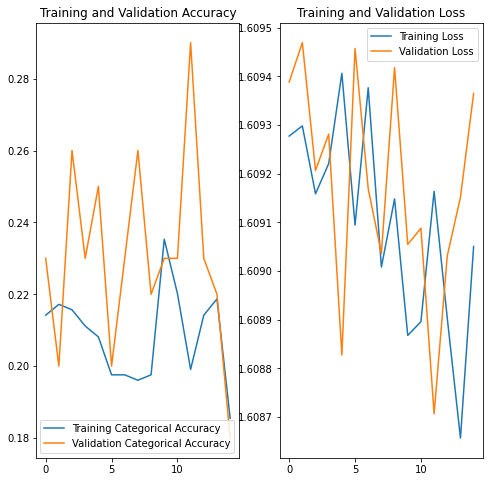

In [ ]:
model_cnnlstm_trainer2 = GeneratorTrainingBuilder(base_path=data_dir, batch_size = 40, img_height_width=(100, 100), img_idx=img_idx2)
model_cnnlstm_out2 = model_cnnlstm_trainer2.train(model=model_cnnlstm, num_epochs=15, model_identifier_name='_model_cnnlstm2')

### More LSTM layers with lesser memory cells and medium epoch

#### CNN LSTM Model 3

In [ ]:
model_cnnlstm3 = Sequential()
img_idx2=[1,2,3,7,8,9,12,14,15,16,19,20,21,24,26,27,28]
img_height_width = (100,100)
input_shape = (len(img_idx2),img_height_width[0],img_height_width[1],3)
input_shape = (len(img_idx2),img_height_width[0],img_height_width[1],3)

model_cnnlstm3.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=input_shape))
model_cnnlstm3.add(TimeDistributed(BatchNormalization()))
model_cnnlstm3.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnnlstm3.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_cnnlstm3.add(TimeDistributed(BatchNormalization()))
model_cnnlstm3.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnnlstm3.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_cnnlstm3.add(TimeDistributed(BatchNormalization()))
model_cnnlstm3.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnnlstm3.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_cnnlstm3.add(TimeDistributed(BatchNormalization()))
model_cnnlstm3.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnnlstm3.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_cnnlstm3.add(TimeDistributed(BatchNormalization()))
model_cnnlstm3.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnnlstm3.add(TimeDistributed(Flatten()))

model_cnnlstm3.add(LSTM(64))
model_cnnlstm3.add(Dropout(0.25))

model_cnnlstm3.add(Dense(64,activation='relu'))
model_cnnlstm3.add(Dropout(0.25))

model_cnnlstm3.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam()
model_cnnlstm3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_cnnlstm3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 17, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 17, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_18 (TimeDis (None, 17, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 17, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 17, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_21 (TimeDis (None, 17, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 17, 25, 25, 64)   

# training sequences = 663
# validation sequences = 100
# epochs = 30
# steps per epoch = 14
# validation steps =  2

 Source path =  gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Project_data/train ; batch size = 50 ;image dimension=  (100, 100)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 1.5933 - categorical_accuracy: 0.2550
 Source path =  gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Project_data/val ; batch size = 50 ;image dimension=  (100, 100)
14/14 [==============================] - 51s 4s/step - loss: 1.5878 - categorical_accuracy: 0.2583 - val_loss: 1.6833 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 1.68329, saving model to gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Gest_recog_model_cnnlstm3_2021-04-2915_29_32.118115/model-00001-1.51007-0.30468-1.68329-0.21000.h5
Epoch 2/30
14/14 [==============================] - 50s 4s/step - loss: 1.2808 - categorical_accuracy: 0.4841 - val_loss: 1.8132 - val_categorical_accuracy: 0.2100

Epoch 00002: val_loss did not improve from 1.68329
Epoch 3/30
14/14 [==============================] - 49s 4s/step - loss: 1.2049 - categorical_accuracy: 0.5168 - val_loss: 1.6921 - val_categorical_accurac

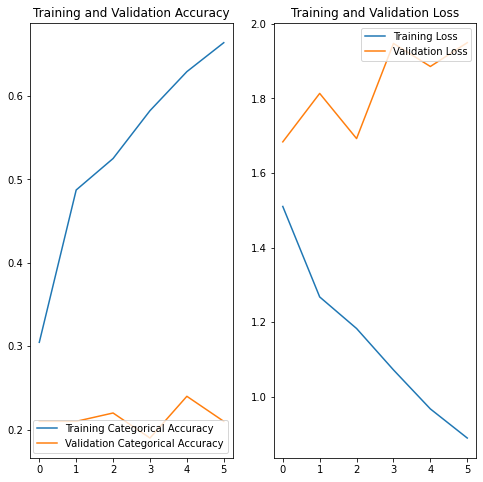

In [ ]:
model_cnnlstm_trainer3 = GeneratorTrainingBuilder(base_path=data_dir, batch_size = 50, img_height_width=img_height_width, img_idx=img_idx2)
model_cnnlstm_out3 = model_cnnlstm_trainer3.train(model=model_cnnlstm3, num_epochs=30, model_identifier_name='_model_cnnlstm3')

Accuracy is not great for the above model . Lets try same model with a much bigger batch size.

### CNN LSTM4

# training sequences = 663
# validation sequences = 100
# epochs = 40
# steps per epoch = 14
# validation steps =  2

 Source path =  gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Project_data/train ; batch size = 50 ;image dimension=  (100, 100)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
14/14 [==============================] - ETA: 0s - loss: 0.7735 - categorical_accuracy: 0.7315
 Source path =  gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Project_data/val ; batch size = 50 ;image dimension=  (100, 100)
14/14 [==============================] - 50s 4s/step - loss: 0.7735 - categorical_accuracy: 0.7315 - val_loss: 1.9061 - val_categorical_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 1.90612, saving model to gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Gest_recog_model_cnnlstm3_1_2021-04-2915_58_21.032166/model-00001-0.77347-0.73152-1.90612-0.25000.h5
Epoch 2/40
14/14 [==============================] - 49s 4s/step - loss: 0.7052 - categorical_accuracy: 0.7617 - val_loss: 1.9473 - val_categorical_accuracy: 0.2700

Epoch 00002: val_loss did not improve from 1.90612
Epoch 3/40
14/14 [==============================] - 49s 4s/step - loss: 0.6474 - categorical_accuracy: 0.7692 - val_loss: 1.8883 - val_categorical_accur

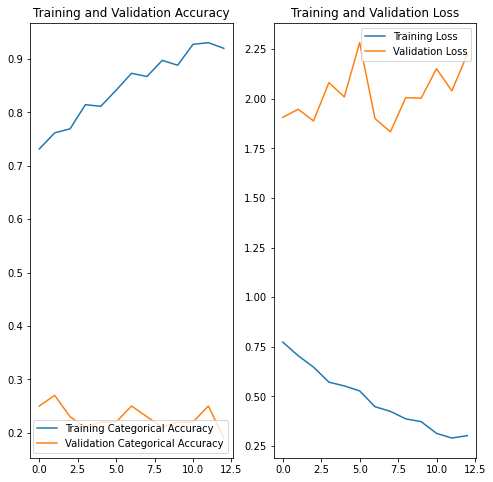

In [ ]:
#Same Model with more batch_size :

model_cnnlstm_trainer3_1 = GeneratorTrainingBuilder(base_path=data_dir, batch_size = 70, img_height_width=img_height_width, img_idx=img_idx2)
model_cnnlstm_out3_1 = model_cnnlstm_trainer3.train(model=model_cnnlstm3, num_epochs=40, model_identifier_name='_model_cnnlstm3_1')

High overfitting experienced. Lets try GRU with some other tuning

### CNN LSTM Model 5

Let change the image size 

In [ ]:
#CNN LSTM Model 5
model_cnnlstm3 = Sequential()
img_idx2=[1,2,3,7,8,9,12,14,15,16,19,20,21,24,26,27,28]
img_height_width = (120,120)

input_shape = (len(img_idx2),img_height_width[0],img_height_width[1],3)

model_cnnlstm3.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=input_shape))
model_cnnlstm3.add(TimeDistributed(BatchNormalization()))
model_cnnlstm3.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnnlstm3.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_cnnlstm3.add(TimeDistributed(BatchNormalization()))
model_cnnlstm3.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnnlstm3.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_cnnlstm3.add(TimeDistributed(BatchNormalization()))
model_cnnlstm3.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnnlstm3.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_cnnlstm3.add(TimeDistributed(BatchNormalization()))
model_cnnlstm3.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnnlstm3.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_cnnlstm3.add(TimeDistributed(BatchNormalization()))
model_cnnlstm3.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnnlstm3.add(TimeDistributed(Flatten()))

model_cnnlstm3.add(LSTM(64))
model_cnnlstm3.add(Dropout(0.2))

model_cnnlstm3.add(Dense(64,activation='relu'))
model_cnnlstm3.add(Dropout(0.2))

model_cnnlstm3.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam()
model_cnnlstm3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_cnnlstm3.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 17, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 17, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 17, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 17, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 17, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 17, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 17, 30, 30, 64)    1

In [ ]:
# Reduce batch size and epoch
model_cnnlstm_trainer5_1 = GeneratorTrainingBuilder(base_path=data_dir, batch_size = 40, img_height_width=img_height_width, img_idx=img_idx2)
model_cnnlstm_out5_1 = model_cnnlstm_trainer5_1.train(model=model_cnnlstm3, num_epochs=40, model_identifier_name='_model_cnnlstm5_1')

# training sequences = 663
# validation sequences = 100
# epochs = 40
# steps per epoch = 17
# validation steps =  3

 Source path =  gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Project_data/train ; batch size = 40 ;image dimension=  (120, 120)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
 7/17 [===========>..................] - ETA: 50:11 - loss: 1.6027 - categorical_accuracy: 0.2869

Didnot improve much with image dimension change 

### CNN GRU Model 1

In [ ]:
model_cnngru1 = Sequential()
img_idx4=[x for x in range(0,30)]
img_height_width = (100,100)
input_shape = (len(img_idx4),img_height_width[0],img_height_width[1],3)

model_cnngru1.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=input_shape))
model_cnngru1.add(TimeDistributed(BatchNormalization()))
model_cnngru1.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnngru1.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_cnngru1.add(TimeDistributed(BatchNormalization()))
model_cnngru1.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnngru1.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_cnngru1.add(TimeDistributed(BatchNormalization()))
model_cnngru1.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnngru1.add(Dropout(0.2))

model_cnngru1.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_cnngru1.add(TimeDistributed(BatchNormalization()))
model_cnngru1.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnngru1.add(TimeDistributed(Flatten()))

model_cnngru1.add(GRU(64))
model_cnngru1.add(Dropout(0.2))

model_cnngru1.add(Dense(64,activation='relu'))
model_cnngru1.add(Dropout(0.2))

model_cnngru1.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam(lr=0.0002)
model_cnngru1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_cnngru1.summary())




Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_32 (TimeDis (None, 30, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_33 (TimeDis (None, 30, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_34 (TimeDis (None, 30, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_35 (TimeDis (None, 30, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_36 (TimeDis (None, 30, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_37 (TimeDis (None, 30, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_38 (TimeDis (None, 30, 25, 25, 64)   

# training sequences = 663
# validation sequences = 100
# epochs = 40
# steps per epoch = 14
# validation steps =  2

 Source path =  gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Project_data/train ; batch size = 50 ;image dimension=  (100, 100)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
14/14 [==============================] - ETA: 0s - loss: 1.6698 - categorical_accuracy: 0.2570  
 Source path =  gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Project_data/val ; batch size = 50 ;image dimension=  (100, 100)
14/14 [==============================] - 2820s 217s/step - loss: 1.6639 - categorical_accuracy: 0.2607 - val_loss: 1.6147 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Gest_recog_model_cnnlstm3_1_2021-04-2916_22_00.995055/model-00001-1.58187-0.31222-1.61465-0.21000.h5
Epoch 2/40
14/14 [==============================] - 88s 7s/step - loss: 1.3213 - categorical_accuracy: 0.4564 - val_loss: 1.7199 - val_categorical_accuracy: 0.1900

Epoch 00002: saving model to gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Gest_recog_model_cnnlstm3_1_2021-04-2916_22_00.995055/model-00002-1.25544-0.48115-1.71987-0.19000.h5
Epoch 3/40
14/14 [===========================

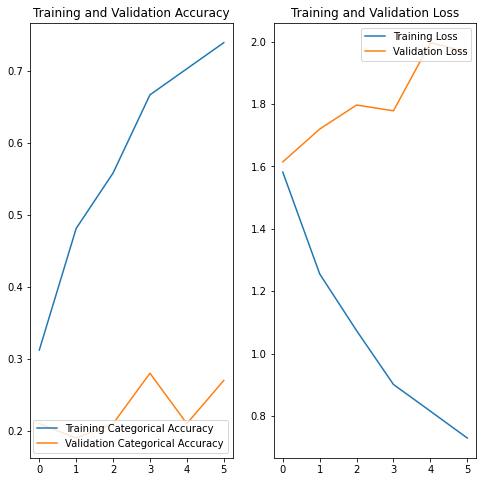

In [ ]:
model_cnngru_trainer1 = GeneratorTrainingBuilder(base_path=data_dir, batch_size = 50, img_height_width=img_height_width, img_idx=img_idx4)
model_cnngru_out1 = model_cnngru_trainer1.train(model=model_cnngru1, num_epochs=40, model_identifier_name='_model_cnnlstm3_1')

In [ ]:
model_cnngru2 = Sequential()
img_idx4=[x for x in range(0,30)]
img_height_width = (100,100)
input_shape = (len(img_idx4),img_height_width[0],img_height_width[1],3)

model_cnngru2.add(TimeDistributed(Conv2D(16, (2, 2) , padding='same', activation='relu'),
                          input_shape=input_shape))
model_cnngru2.add(TimeDistributed(BatchNormalization()))
model_cnngru2.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnngru2.add(TimeDistributed(Conv2D(32, (2, 2) , padding='same', activation='relu')))
model_cnngru2.add(TimeDistributed(BatchNormalization()))
model_cnngru2.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnngru2.add(TimeDistributed(Conv2D(64, (2, 2) , padding='same', activation='relu')))
model_cnngru2.add(TimeDistributed(BatchNormalization()))
model_cnngru2.add(TimeDistributed(MaxPooling2D((2, 2))))


model_cnngru2.add(TimeDistributed(Conv2D(128, (2, 2) , padding='same', activation='relu')))
model_cnngru2.add(TimeDistributed(BatchNormalization()))
model_cnngru2.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnngru2.add(TimeDistributed(Conv2D(256, (2, 2) , padding='same', activation='relu')))
model_cnngru2.add(TimeDistributed(BatchNormalization()))
model_cnngru2.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnngru2.add(TimeDistributed(Conv2D(512, (2, 2) , padding='same', activation='relu')))
model_cnngru2.add(TimeDistributed(BatchNormalization()))
model_cnngru2.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnngru2.add(TimeDistributed(Flatten()))

model_cnngru2.add(GRU(128))
model_cnngru2.add(Dense(128,activation='relu'))
model_cnngru2.add(Dropout(0.2))

model_cnngru2.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam(lr=0.0001)
model_cnngru2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_cnngru2.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_137 (TimeDi (None, 30, 100, 100, 16)  208       
_________________________________________________________________
time_distributed_138 (TimeDi (None, 30, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_139 (TimeDi (None, 30, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_140 (TimeDi (None, 30, 50, 50, 32)    2080      
_________________________________________________________________
time_distributed_141 (TimeDi (None, 30, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_142 (TimeDi (None, 30, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_143 (TimeDi (None, 30, 25, 25, 64)   

# training sequences = 663
# validation sequences = 100
# epochs = 50
# steps per epoch = 14
# validation steps =  2

 Source path =  gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Project_data/train ; batch size = 50 ;image dimension=  (100, 100)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 1.5908 - categorical_accuracy: 0.2523
 Source path =  gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Project_data/val ; batch size = 50 ;image dimension=  (100, 100)
14/14 [==============================] - 91s 7s/step - loss: 1.5865 - categorical_accuracy: 0.2558 - val_loss: 1.6171 - val_categorical_accuracy: 0.1800

Epoch 00001: saving model to gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Gest_recog_model_cnngru_2_2021-04-2917_31_37.902358/model-00001-1.52554-0.30468-1.61715-0.18000.h5
Epoch 2/50
14/14 [==============================] - 86s 7s/step - loss: 1.0837 - categorical_accuracy: 0.6212 - val_loss: 1.6754 - val_categorical_accuracy: 0.1500

Epoch 00002: saving model to gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Gest_recog_model_cnngru_2_2021-04-2917_31_37.902358/model-00002-1.05411-0.63047-1.67537-0.15000.h5
Epoch 3/50
14/14 [==============================] - 86s

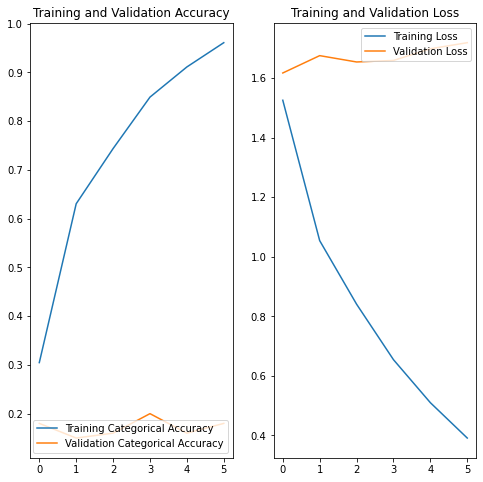

In [ ]:
model_cnngru_trainer2 = GeneratorTrainingBuilder(base_path=data_dir, batch_size = 40, img_height_width=img_height_width, img_idx=img_idx4)
model_cnngru_out2 = model_cnngru_trainer1.train(model=model_cnngru2, num_epochs=50, model_identifier_name='_model_cnngru_2')

In [ ]:
model_cnnlstm4 = Sequential()
img_idx4=[x for x in range(0,30)]
img_height_width = (100,100)
input_shape = (len(img_idx4),img_height_width[0],img_height_width[1],3)

model_cnnlstm4.add(TimeDistributed(Conv2D(16, (2, 2) , padding='same', activation='relu'),
                          input_shape=input_shape))
model_cnnlstm4.add(TimeDistributed(BatchNormalization()))
model_cnnlstm4.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnnlstm4.add(TimeDistributed(Conv2D(32, (2, 2) , padding='same', activation='relu')))
model_cnnlstm4.add(TimeDistributed(BatchNormalization()))
model_cnnlstm4.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnnlstm4.add(TimeDistributed(Conv2D(64, (2, 2) , padding='same', activation='relu')))
model_cnnlstm4.add(TimeDistributed(BatchNormalization()))
model_cnnlstm4.add(TimeDistributed(MaxPooling2D((2, 2))))


model_cnnlstm4.add(TimeDistributed(Conv2D(128, (2, 2) , padding='same', activation='relu')))
model_cnnlstm4.add(TimeDistributed(BatchNormalization()))
model_cnnlstm4.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnnlstm4.add(TimeDistributed(Conv2D(256, (2, 2) , padding='same', activation='relu')))
model_cnnlstm4.add(TimeDistributed(BatchNormalization()))
model_cnnlstm4.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnnlstm4.add(TimeDistributed(Conv2D(512, (2, 2) , padding='same', activation='relu')))
model_cnnlstm4.add(TimeDistributed(BatchNormalization()))
model_cnnlstm4.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnnlstm4.add(TimeDistributed(Flatten()))

model_cnnlstm4.add(LSTM(128))
model_cnnlstm4.add(Dense(128,activation='relu'))
model_cnnlstm4.add(Dropout(0.2))

model_cnnlstm4.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam(lr=0.0001)
model_cnnlstm4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_cnnlstm4.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_156 (TimeDi (None, 30, 100, 100, 16)  208       
_________________________________________________________________
time_distributed_157 (TimeDi (None, 30, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_158 (TimeDi (None, 30, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_159 (TimeDi (None, 30, 50, 50, 32)    2080      
_________________________________________________________________
time_distributed_160 (TimeDi (None, 30, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_161 (TimeDi (None, 30, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_162 (TimeDi (None, 30, 25, 25, 64)  

# training sequences = 663
# validation sequences = 100
# epochs = 50
# steps per epoch = 14
# validation steps =  2

 Source path =  gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Project_data/train ; batch size = 50 ;image dimension=  (100, 100)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 1.5554 - categorical_accuracy: 0.3142
 Source path =  gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Project_data/val ; batch size = 50 ;image dimension=  (100, 100)
14/14 [==============================] - 90s 7s/step - loss: 1.5513 - categorical_accuracy: 0.3165 - val_loss: 1.6120 - val_categorical_accuracy: 0.1700

Epoch 00001: saving model to gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Gest_recog_model_cnnlstm_4_2021-04-2917_48_54.804898/model-00001-1.49375-0.34842-1.61197-0.17000.h5
Epoch 2/50
14/14 [==============================] - 86s 7s/step - loss: 1.2086 - categorical_accuracy: 0.5954 - val_loss: 1.6134 - val_categorical_accuracy: 0.1700

Epoch 00002: saving model to gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Gest_recog_model_cnnlstm_4_2021-04-2917_48_54.804898/model-00002-1.18373-0.60633-1.61344-0.17000.h5
Epoch 3/50
14/14 [==============================] - 8

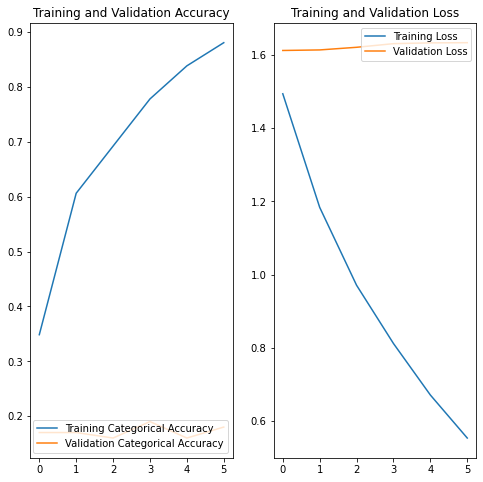

In [ ]:
model_cnnlstm_trainer4 = GeneratorTrainingBuilder(base_path=data_dir, batch_size = 30, img_height_width=img_height_width, img_idx=img_idx4)
model_cnnlstm_out4 = model_cnngru_trainer1.train(model=model_cnnlstm4, num_epochs=50, model_identifier_name='_model_cnnlstm_4')

## Lets try with a Transfer learning from Mobilenet + LSTM

In [ ]:
from keras.applications import mobilenet
transfer_ml = mobilenet.MobileNet(weights='imagenet', include_top=False)

model_tl_imagenet = Sequential()
model_tl_imagenet.add(TimeDistributed(transfer_ml,input_shape=input_shape))


for layer in model_tl_imagenet.layers:
    layer.trainable = False


model_tl_imagenet.add(TimeDistributed(BatchNormalization()))
model_tl_imagenet.add(TimeDistributed(MaxPooling2D((2, 2))))
model_tl_imagenet.add(TimeDistributed(Flatten()))

model_tl_imagenet.add(LSTM(64))
model_tl_imagenet.add(Dropout(0.2))

model_tl_imagenet.add(Dense(64,activation='relu'))
model_tl_imagenet.add(Dropout(0.2))

model_tl_imagenet.add(Dense(5, activation ='softmax'))


optimiser = optimizers.Adam(lr=0.01)
model_tl_imagenet.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_tl_imagenet.summary())

17227776/17225924 [==============================] - 0s 0us/step
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_175 (TimeDi (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_176 (TimeDi (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_177 (TimeDi (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_178 (TimeDi (None, 30, 1024)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                278784    
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
______________________________________________________

# training sequences = 663
# validation sequences = 100
# epochs = 20
# steps per epoch = 23
# validation steps =  4

 Source path =  gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Project_data/train ; batch size = 30 ;image dimension=  (100, 100)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.5179 - categorical_accuracy: 0.3013
 Source path =  gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Project_data/val ; batch size = 30 ;image dimension=  (100, 100)
23/23 [==============================] - 90s 4s/step - loss: 1.5117 - categorical_accuracy: 0.3052 - val_loss: 1.0076 - val_categorical_accuracy: 0.6600

Epoch 00001: saving model to gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Gest_recog_model_tl_imagenet_1_2021-04-2918_41_37.977291/model-00001-1.37029-0.39517-1.00759-0.66000.h5
Epoch 2/20
23/23 [==============================] - 86s 4s/step - loss: 0.8992 - categorical_accuracy: 0.6501 - val_loss: 0.8248 - val_categorical_accuracy: 0.7200

Epoch 00002: saving model to gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Gest_recog_model_tl_imagenet_1_2021-04-2918_41_37.977291/model-00002-0.88164-0.66516-0.82484-0.72000.h5
Epoch 3/20
23/23 [===========================

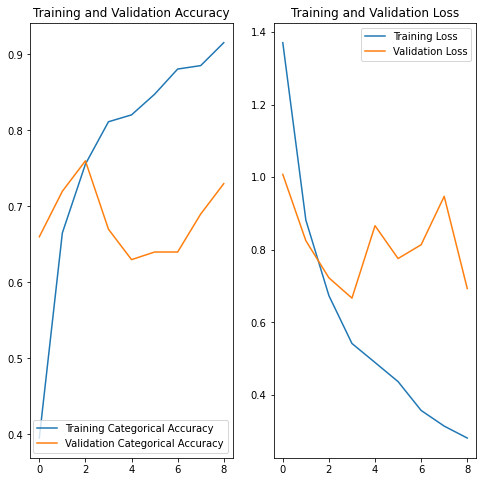

In [ ]:
model_tl_trainer1 = GeneratorTrainingBuilder(base_path=data_dir, batch_size = 30, img_height_width=img_height_width, img_idx=img_idx4)
model_tl_out1 = model_tl_trainer1.train(model=model_tl_imagenet, num_epochs=20, model_identifier_name='_model_tl_imagenet_1')

The above model has a goodgeneralisation ability with almost 75% in both Train and validation accuracy !

### TL + LSTM with trainable weights 

In [ ]:

transfer_ml = mobilenet.MobileNet(weights='imagenet', include_top=False)

model_tl2_imagenet = Sequential()
model_tl2_imagenet.add(TimeDistributed(transfer_ml,input_shape=input_shape))


#Have the layers trainable
# for layer in model_tl_imagenet.layers:
#     layer.trainable = False


model_tl2_imagenet.add(TimeDistributed(BatchNormalization()))
model_tl2_imagenet.add(TimeDistributed(MaxPooling2D((2, 2))))
model_tl2_imagenet.add(TimeDistributed(Flatten()))

model_tl2_imagenet.add(LSTM(64))
model_tl2_imagenet.add(Dropout(0.2))

model_tl2_imagenet.add(Dense(64,activation='relu'))
model_tl2_imagenet.add(Dropout(0.2))

model_tl2_imagenet.add(Dense(5, activation='softmax'))


optimiser = optimizers.Adam(lr=0.01)
model_tl2_imagenet.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_tl2_imagenet.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_183 (TimeDi (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_184 (TimeDi (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_185 (TimeDi (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_186 (TimeDi (None, 30, 1024)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                278784    
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)              

# training sequences = 663
# validation sequences = 100
# epochs = 20
# steps per epoch = 17
# validation steps =  3

 Source path =  gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Project_data/train ; batch size = 40 ;image dimension=  (100, 100)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.5241 - categorical_accuracy: 0.3125
 Source path =  gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Project_data/val ; batch size = 40 ;image dimension=  (100, 100)
17/17 [==============================] - 93s 5s/step - loss: 1.5199 - categorical_accuracy: 0.3163 - val_loss: 1.9551 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Gest_recog_model_tl2_imagenet_1_2021-04-2919_30_01.840444/model-00001-1.44879-0.38160-1.95507-0.16000.h5
Epoch 2/20
17/17 [==============================] - 88s 5s/step - loss: 1.3372 - categorical_accuracy: 0.4321 - val_loss: 1.6694 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to gdrive/My Drive/DeepLearning/Assignment2_Gesture_recognition/Gest_recog_model_tl2_imagenet_1_2021-04-2919_30_01.840444/model-00002-1.35536-0.43891-1.66943-0.23000.h5
Epoch 3/20
17/17 [=========================

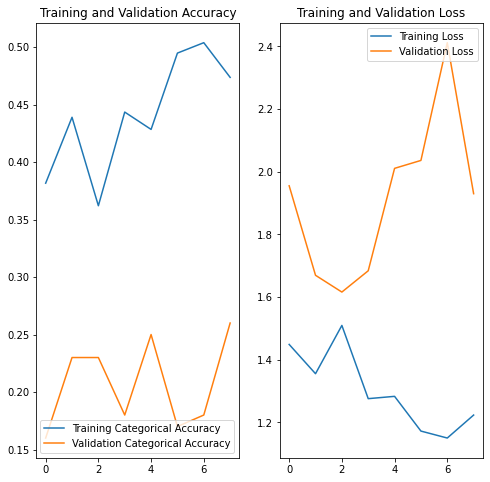

In [ ]:
model_tl2_trainer1 = GeneratorTrainingBuilder(base_path=data_dir, batch_size = 40, img_height_width=img_height_width, img_idx=img_idx4)
model_tl2_out1 = model_tl2_trainer1.train(model=model_tl2_imagenet, num_epochs=20, model_identifier_name='_model_tl2_imagenet_1')

Retraining the weights from Mobilenet didnt perform good in both train and validation sets.

### Transfer Learning with GRU 


In [ ]:

transfer_ml2 = mobilenet.MobileNet(weights='imagenet', include_top=False)
img_idx4=[x for x in range(0,30)]
img_height_width = (100,100)
input_shape = (len(img_idx4),img_height_width[0],img_height_width[1],3)


model_tl_imagenet2 = Sequential()
model_tl_imagenet2.add(TimeDistributed(transfer_ml2,input_shape=input_shape))


for layer in model_tl_imagenet2.layers:
    layer.trainable = False


model_tl_imagenet2.add(TimeDistributed(BatchNormalization()))
model_tl_imagenet2.add(TimeDistributed(MaxPooling2D((2, 2))))
model_tl_imagenet2.add(TimeDistributed(Flatten()))

model_tl_imagenet2.add(GRU(64))
model_tl_imagenet2.add(Dropout(0.2))

model_tl_imagenet2.add(Dense(64,activation='relu'))
model_tl_imagenet2.add(Dropout(0.2))

model_tl_imagenet2.add(Dense(5, activation ='softmax'))


optimiser = optimizers.Adam(lr=0.01)
model_tl_imagenet2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_tl_imagenet2.summary())

17227776/17225924 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 1024)          0         
_________________________________________________________________
gru (GRU)                    (None, 64)                209280    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________

# training sequences = 663
# validation sequences = 100
# epochs = 20
# steps per epoch = 17
# validation steps =  3

 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 40 ;image dimension=  (120, 120)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 0.7966 - categorical_accuracy: 0.7044 
 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/val ; batch size = 40 ;image dimension=  (120, 120)
17/17 [==============================] - 895s 56s/step - loss: 0.7966 - categorical_accuracy: 0.7044 - val_loss: 0.7316 - val_categorical_accuracy: 0.7100

Epoch 00001: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Gest_recog_model_tl2_imagenet_1_gru_2021-05-0218_10_18.221587/model-00001-0.79660-0.70437-0.73161-0.71000.h5
Epoch 2/20
17/17 [==============================] - 114s 7s/step - loss: 0.4030 - categorical_accuracy: 0.8431 - val_loss: 0.7513 - val_categorical_accuracy: 0.7000

Epoch 00002: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Gest_recog_model_tl2_imagenet_1_gru_2021-05-0218_10_18.221587/model-00002-0.40302-0.84314-0.75130-0.70000.h5
Epoch 3/20
17/17 [==============================] - 110s 7s/step - loss: 0.3524 - 

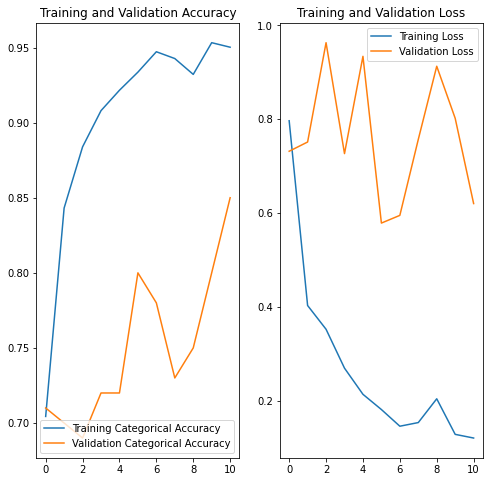

In [ ]:
model_tl2_trainer1_gru = GeneratorTrainingBuilder(base_path=data_dir, batch_size = 40, img_height_width=img_height_width, img_idx=img_idx4)
model_tl2_out1_gru = model_tl2_trainer1_gru.train(model=model_tl_imagenet2, num_epochs=20, 
                                                  model_identifier_name='_model_tl2_imagenet_1_gru')

Transfer learning with GRU performed much better and generalised the model with validation accuracy of approx 85% and Train accuracy of 95%.

### Transfer Learning + GRU + different image dimension

In [ ]:

transfer_ml2 = mobilenet.MobileNet(weights='imagenet', include_top=False)
img_idx4=[x for x in range(0,30)]
img_height_width = (120,120)
input_shape = (len(img_idx4),img_height_width[0],img_height_width[1],3)


model_tl_imagenet2 = Sequential()
model_tl_imagenet2.add(TimeDistributed(transfer_ml2,input_shape=input_shape))


for layer in model_tl_imagenet2.layers:
    layer.trainable = False


model_tl_imagenet2.add(TimeDistributed(BatchNormalization()))
model_tl_imagenet2.add(TimeDistributed(MaxPooling2D((2, 2))))
model_tl_imagenet2.add(TimeDistributed(Flatten()))

model_tl_imagenet2.add(GRU(64))
model_tl_imagenet2.add(Dropout(0.2))

model_tl_imagenet2.add(Dense(64,activation='relu'))
model_tl_imagenet2.add(Dropout(0.2))

model_tl_imagenet2.add(Dense(5, activation ='softmax'))


optimiser = optimizers.Adam(lr=0.01)
model_tl_imagenet2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_tl_imagenet2.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                209280    
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

# training sequences = 663
# validation sequences = 100
# epochs = 20
# steps per epoch = 17
# validation steps =  3

 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 40 ;image dimension=  (120, 120)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.5765 - categorical_accuracy: 0.3564
 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/val ; batch size = 40 ;image dimension=  (120, 120)
17/17 [==============================] - 119s 7s/step - loss: 1.5650 - categorical_accuracy: 0.3618 - val_loss: 1.3058 - val_categorical_accuracy: 0.4500

Epoch 00001: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Gest_recog_model_tl2_imagenet_2_gru2_2021-05-0219_00_19.696620/model-00001-1.36864-0.45249-1.30575-0.45000.h5
Epoch 2/20
17/17 [==============================] - 113s 7s/step - loss: 0.8012 - categorical_accuracy: 0.7102 - val_loss: 0.9101 - val_categorical_accuracy: 0.7200

Epoch 00002: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Gest_recog_model_tl2_imagenet_2_gru2_2021-05-0219_00_19.696620/model-00002-0.69092-0.74962-0.91014-0.72000.h5
Epoch 3/20
17/17 [==============================] - 109s 7s/step - loss: 0.4900 - 

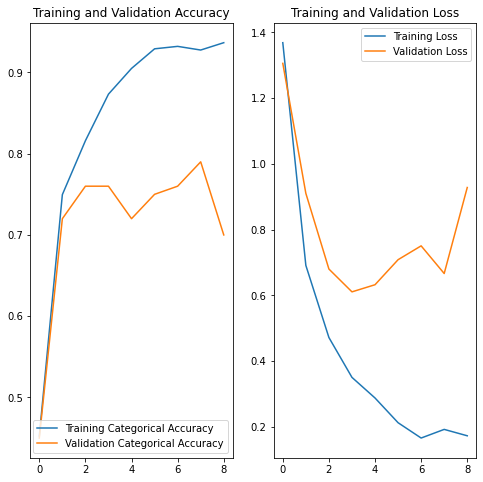

In [ ]:
model_tl2_trainer1_gru2 = GeneratorTrainingBuilder(base_path=data_dir, batch_size = 40, img_height_width=img_height_width, img_idx=img_idx4)
model_tl2_out1_gru2 = model_tl2_trainer1_gru2.train(model=model_tl_imagenet2, num_epochs=20, 
                                                  model_identifier_name='_model_tl2_imagenet_2_gru2')

### Transfer Learning with GRU - Reduce parameters, Reduce batch size

In [ ]:

transfer_ml3 = mobilenet.MobileNet(weights='imagenet', include_top=False)
img_idx2=[2,3,7,8,9,12,15,16,19,20,21,24,26,27,28]
#img_idx4=[x for x in range(0,30)]
img_height_width = (100,100)
input_shape = (len(img_idx2),img_height_width[0],img_height_width[1],3)

model_tl_imagenet3 = Sequential()
model_tl_imagenet3.add(TimeDistributed(transfer_ml3,input_shape=input_shape))

for layer in model_tl_imagenet3.layers:
    layer.trainable = False

model_tl_imagenet3.add(TimeDistributed(BatchNormalization()))
model_tl_imagenet3.add(TimeDistributed(MaxPooling2D((2, 2))))
model_tl_imagenet3.add(TimeDistributed(Flatten()))

model_tl_imagenet3.add(GRU(32))
model_tl_imagenet3.add(Dropout(0.2))

model_tl_imagenet3.add(Dense(64,activation='relu'))
model_tl_imagenet3.add(Dropout(0.2))

model_tl_imagenet3.add(Dense(5, activation ='softmax'))


optimiser = optimizers.Adam(lr=0.001)
model_tl_imagenet3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_tl_imagenet3.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_12 (TimeDis (None, 15, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_13 (TimeDis (None, 15, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_14 (TimeDis (None, 15, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 15, 1024)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                101568    
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)               

# training sequences = 663
# validation sequences = 100
# epochs = 20
# steps per epoch = 34
# validation steps =  5

 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 20 ;image dimension=  (100, 100)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.6225 - categorical_accuracy: 0.2919
 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/val ; batch size = 20 ;image dimension=  (100, 100)
34/34 [==============================] - 60s 2s/step - loss: 1.6186 - categorical_accuracy: 0.2935 - val_loss: 1.2670 - val_categorical_accuracy: 0.5100

Epoch 00001: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Gest_recog_model_tl2_imagenet2_gru3_2021-05-0219_22_40.983687/model-00001-1.48664-0.34992-1.26702-0.51000.h5
Epoch 2/20
34/34 [==============================] - 55s 2s/step - loss: 1.0091 - categorical_accuracy: 0.6357 - val_loss: 1.0164 - val_categorical_accuracy: 0.6200

Epoch 00002: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Gest_recog_model_tl2_imagenet2_gru3_2021-05-0219_22_40.983687/model-00002-0.99133-0.64253-1.01637-0.62000.h5
Epoch 3/20
34/34 [==============================] - 56s 2s/step - loss: 0.7023 - categ

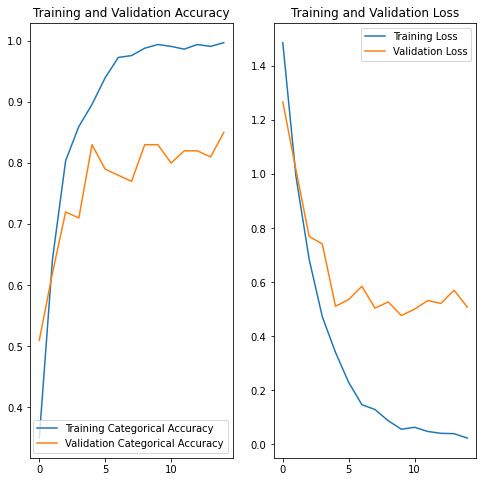

In [ ]:
model_tl3_trainer_gru = GeneratorTrainingBuilder(base_path=data_dir, batch_size = 20, img_height_width=img_height_width, img_idx=img_idx2)
model_tl3_out1_gru = model_tl3_trainer_gru.train(model=model_tl_imagenet3, num_epochs=20, 
                                                  model_identifier_name='_model_tl2_imagenet2_gru3')

### Transfer Learning with GRU - Increasing dropouts, reducing the neurons in hidden layer

In [ ]:

transfer_ml4 = mobilenet.MobileNet(weights='imagenet', include_top=False)
img_idx2=[2,3,7,8,9,12,15,16,19,20,21,24,26,27]
#img_idx4=[x for x in range(0,30)]
img_height_width = (100,100)
input_shape = (len(img_idx2),img_height_width[0],img_height_width[1],3)

model_tl_imagenet4 = Sequential()
model_tl_imagenet4.add(TimeDistributed(transfer_ml4,input_shape=input_shape))

for layer in model_tl_imagenet4.layers:
    layer.trainable = False

model_tl_imagenet4.add(TimeDistributed(BatchNormalization()))
model_tl_imagenet4.add(TimeDistributed(MaxPooling2D((2, 2))))
model_tl_imagenet4.add(TimeDistributed(Flatten()))

model_tl_imagenet4.add(GRU(32))
model_tl_imagenet4.add(Dropout(0.25))

model_tl_imagenet4.add(Dense(16,activation='relu'))
model_tl_imagenet4.add(Dropout(0.25))

model_tl_imagenet4.add(Dense(5, activation ='softmax'))


optimiser = optimizers.Adam(lr=0.001)
model_tl_imagenet4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_tl_imagenet4.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_28 (TimeDis (None, 14, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_29 (TimeDis (None, 14, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_30 (TimeDis (None, 14, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_31 (TimeDis (None, 14, 1024)          0         
_________________________________________________________________
gru_7 (GRU)                  (None, 32)                101568    
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)               

# training sequences = 663
# validation sequences = 100
# epochs = 20
# steps per epoch = 34
# validation steps =  5

 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 20 ;image dimension=  (100, 100)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.7233 - categorical_accuracy: 0.2370
 Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/val ; batch size = 20 ;image dimension=  (100, 100)
34/34 [==============================] - 57s 2s/step - loss: 1.7198 - categorical_accuracy: 0.2385 - val_loss: 1.4083 - val_categorical_accuracy: 0.3300

Epoch 00001: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Gest_recog_model_tl2_imagenet2_gru4_2021-05-0220_39_44.780954/model-00001-1.60397-0.29110-1.40833-0.33000.h5
Epoch 2/20
34/34 [==============================] - 51s 2s/step - loss: 1.3729 - categorical_accuracy: 0.3910 - val_loss: 1.1370 - val_categorical_accuracy: 0.6400

Epoch 00002: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Gest_recog_model_tl2_imagenet2_gru4_2021-05-0220_39_44.780954/model-00002-1.30811-0.44193-1.13703-0.64000.h5
Epoch 3/20
34/34 [==============================] - 51s 2s/step - loss: 1.0813 - categ

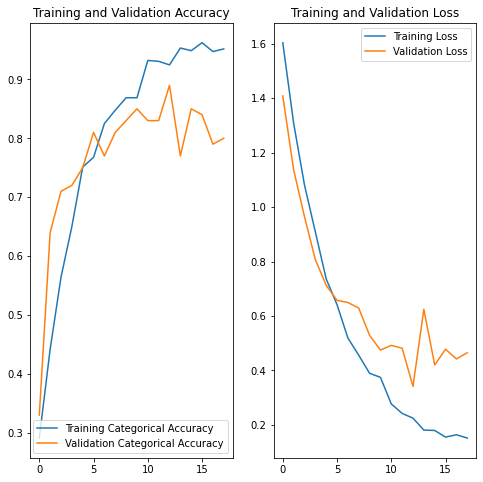

In [ ]:
model_tl4_trainer_gru = GeneratorTrainingBuilder(base_path=data_dir, batch_size = 20, img_height_width=img_height_width, img_idx=img_idx2)
model_tl4_out1_gru = model_tl4_trainer_gru.train(model=model_tl_imagenet4, num_epochs=20, 
                                                  model_identifier_name='_model_tl2_imagenet2_gru4')